In [50]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge 
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

Loading data and minor cleaning/checking:

In [35]:
#load data
data=pd.read_csv('headlinesNLPdata.csv')
data=data.drop(labels=['Unnamed: 0','Headlines','date'], axis='columns')
print(data.columns)

#create dummy variables for the tickers
data=pd.get_dummies(data,columns=['ticker'],prefix='tick',dtype=int)
print(data.columns)

#Checking if we have categorical data
print(data.dtypes)
print(data.select_dtypes(include=['object','category']).head())

#Checking numeric feature ranges 
data.describe().T[['min','max']]

Index(['ticker', 'return', 'direction', 'headline_length', 'word_count',
       'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'neg_sentiment', 'neu_sentiment', 'pos_sentiment', 'compound_sentiment',
       'finbert_neg', 'finbert_neu', 'finbert_pos', '01', '02', '03', '05',
       '06', '10', '19', '1h', 'announces', 'bank', 'beat', 'beats', 'capital',
       'ceo', 'covid', 'deal', 'declares', 'dividend', 'earnings', 'energy',
       'eps', 'estimates', 'ffo', 'financial', 'gainers', 'group', 'guidance',
       'high', 'launches', 'line', 'losers', 'misses', 'new', 'notes',
       'offering', 'pandemic', 'prices', 'q2', 'reports', 'results', 'revenue',
       'sales', 'says', 'sees', 'shares', 'strong', 'study', 'technologies',
       'therapeutics', 'vaccine'],
      dtype='object')
Index(['return', 'direction', 'headline_length', 'word_count', 'day_0',
       'day_1', 'day_2', 'day_3', 'day_4', 'day_5',
       ...
       'tick_ZM', 'tick_ZNTL', 'tick_ZS', 'ti

,min,max
return,-0.581818,3.18136
direction,0.000000,1.00000
headline_length,18.000000,160.00000
word_count,3.000000,21.00000
day_0,0.000000,1.00000
...,...,...
tick_ZTR,0.000000,1.00000
tick_ZTS,0.000000,1.00000
tick_ZURVY,0.000000,1.00000
tick_ZYME,0.000000,1.00000


Data Preprocessing

In [36]:
#Separating features 
X=data.drop(columns=['return','direction'])
y=data['return']

#Standardizing numeric features (all features should be numeric anyways)
numeric_cols=X.select_dtypes(include=['int64','float64']).columns
scaler=StandardScaler()
X_scaled=X.copy()
X_scaled[numeric_cols]=scaler.fit_transform(X[numeric_cols])

#Split into train and test sets 80/20
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=42)

We made sure to drop the return and direction values from our input data, as these features are relevant to the result which we seek to predict. Previously, we used 'direction' as one of the input features and obtained unrealistic results for directional accuracy. 

Ridge Regression (GridSearchCV)

In [37]:
ridge=Ridge()
ridge_params={'alpha':[0.01,0.1,1,10,50,100]}
grid_ridge=GridSearchCV(ridge,ridge_params,cv=5,scoring='neg_mean_squared_error') #negative MSE scoring, to minimize MSE by maximizing scoring metric
grid_ridge.fit(X_train,y_train)
best_ridge=grid_ridge.best_estimator_
y_pred_ridge=best_ridge.predict(X_test)
y_true_bin=(np.sign(y_test)>0).astype(int)
y_pred_bin=(np.sign(y_pred_ridge)>0).astype(int)

ridge_mse=mean_squared_error(y_test,y_pred_ridge) #MSE
ridge_mae=mean_absolute_error(y_test,y_pred_ridge) #MAE
ridge_r2=r2_score(y_test,y_pred_ridge) #r2 score
ridge_dir_acc=np.mean(np.sign(y_pred_ridge)==np.sign(y_test)) #direction of return accuracy
ridge_prec=precision_score(y_true_bin,y_pred_bin)
ridge_rec=recall_score(y_true_bin,y_pred_bin)
ridge_f1=f1_score(y_true_bin,y_pred_bin)

print("Ridge Regression:")
print("Best alpha: ",grid_ridge.best_params_)
print(f"MSE: {ridge_mse:.4f}, MAE: {ridge_mae:.4f}, R²: {ridge_r2:.4f}, Direction Accuracy: {ridge_dir_acc:.4f}\n, Direction Precision: {ridge_prec:.4f}\n, Direction Recall: {ridge_rec:.4f}\n, Direction F1: {ridge_f1:.4f}\n")


Ridge Regression:
Best alpha:  {'alpha': 100}
MSE: 0.0058, MAE: 0.0400, R²: -0.5550, Direction Accuracy: 0.5616
, Direction Precision: 0.5496
, Direction Recall: 0.5980
, Direction F1: 0.5728



Ridge regression is a linear model with one hyperparameter (alpha). Thus we use GridSearchCV here which is efficient since we can exhaustively test a small range of values.

Random Forest (RandomizedSearchCV)

In [38]:
rf=RandomForestRegressor(random_state=42)
rf_param_dist={
    'n_estimators':[100,200,500,1000],
    'max_depth':[5,10,20,None],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}
rf_random=RandomizedSearchCV(rf,param_distributions=rf_param_dist,n_iter=10,cv=3,scoring='neg_mean_squared_error',n_jobs=-1,random_state=42)
rf_random.fit(X_train,y_train)
best_rf=rf_random.best_estimator_
y_pred_rf=best_rf.predict(X_test)
y_true_bin=(np.sign(y_test)>0).astype(int)
y_pred_bin=(np.sign(y_pred_rf)>0).astype(int)

rf_mse=mean_squared_error(y_test,y_pred_rf)
rf_mae=mean_absolute_error(y_test,y_pred_rf)
rf_r2=r2_score(y_test,y_pred_rf)
rf_dir_acc=np.mean(np.sign(y_pred_rf)==np.sign(y_test))
rf_prec=precision_score(y_true_bin,y_pred_bin)
rf_rec=recall_score(y_true_bin,y_pred_bin)
rf_f1=f1_score(y_true_bin,y_pred_bin)

print("Random Forest:")
print("Best params:",rf_random.best_params_)
print(f"MSE: {rf_mse:.4f}, MAE: {rf_mae:.4f}, R²: {rf_r2:.4f}, Direction Accuracy: {rf_dir_acc:.4f}\n, Direction Precision: {rf_prec:.4f}\n, Direction Recall: {rf_rec:.4f}\n, Direction F1: {rf_f1:.4f}\n")

Random Forest:
Best params: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5}
MSE: 0.0052, MAE: 0.0366, R²: -0.3978, Direction Accuracy: 0.4648
, Direction Precision: 0.4640
, Direction Recall: 0.9990
, Direction F1: 0.6337



Random Forest is an ensemble of decision trees capturing non-linear interactions and feature importance. Since it has many hyperparameters, making a full grid search is too expensive so we opt for RandomizedSearchCV which is more practical to find strong configurations quickly.  

XGBoost (RandomizedSearchCV)

In [39]:
xgb=XGBRegressor(random_state=42,objective='reg:squarederror')
xgb_param_dist={
    'n_estimators':[100,200,500],
    'max_depth':[3,5,7],
    'learning_rate':[0.01,0.05,0.1],
    'subsample':[0.6,0.8,1]
}
xgb_random=RandomizedSearchCV(xgb,param_distributions=xgb_param_dist,n_iter=10,cv=3,scoring='neg_mean_squared_error',n_jobs=-1,random_state=42)
xgb_random.fit(X_train,y_train)
best_xgb=xgb_random.best_estimator_
y_pred_xgb=best_xgb.predict(X_test)
y_true_bin=(np.sign(y_test)>0).astype(int)
y_pred_bin=(np.sign(y_pred_xgb)>0).astype(int)

xgb_mse=mean_squared_error(y_test,y_pred_xgb)
xgb_mae=mean_absolute_error(y_test,y_pred_xgb)
xgb_r2=r2_score(y_test,y_pred_xgb)
xgb_dir_acc=np.mean(np.sign(y_pred_xgb)==np.sign(y_test))
xgb_prec=precision_score(y_true_bin,y_pred_bin)
xgb_rec=recall_score(y_true_bin,y_pred_bin)
xgb_f1=f1_score(y_true_bin,y_pred_bin)


print("XGBoost:")
print("Best params:",xgb_random.best_params_)
print(f"MSE: {xgb_mse:.4f}, MAE: {xgb_mae:.4f}, R²: {xgb_r2:.4f}, Direction Accuracy: {xgb_dir_acc:.4f}\n, Direction Precision: {xgb_prec:.4f}\n, Direction Recall: {xgb_rec:.4f}\n, Direction F1: {xgb_f1:.4f}\n")

XGBoost:
Best params: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01}
MSE: 0.0040, MAE: 0.0357, R²: -0.0769, Direction Accuracy: 0.4634
, Direction Precision: 0.4634
, Direction Recall: 1.0000
, Direction F1: 0.6333



XGBoost is a gradient boosting model that works very well on tabular data. Like Random Forest it has many hyperparameters and is better suited to RandomizedSearchCV. 

Comparison

In [43]:
#Feature importance 
ridge_importance=pd.Series(best_ridge.coef_,index=X_train.columns).sort_values(key=abs,ascending=False)
rf_importance=pd.Series(best_rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
xgb_importance=pd.Series(best_xgb.feature_importances_,index=X_train.columns).sort_values(ascending=False)

print("Top Ridge features:\n", ridge_importance.head(5))
print("\nTop RF features:\n", rf_importance.head(5))
print("\nTop XGB features:\n", xgb_importance.head(5))

Top Ridge features:
 tick_KODK    0.027376
tick_ALYI    0.016531
tick_IGC     0.011543
tick_KITL    0.011451
tick_RMBL    0.011344
dtype: float64

Top RF features:
 tick_KODK      0.185184
finbert_pos    0.174993
tick_ALYI      0.108367
finbert_neu    0.088502
tick_IGC       0.083953
dtype: float64

Top XGB features:
 finbert_pos      0.176048
day_1            0.140773
finbert_neu      0.106788
pos_sentiment    0.093537
gainers          0.083908
dtype: float32


In [40]:
results = {
    "Model": ["Ridge", "Random Forest", "XGBoost"],
    "MSE":   [ridge_mse, rf_mse, xgb_mse],
    "MAE":   [ridge_mae, rf_mae, xgb_mae],
    "R²":    [ridge_r2, rf_r2, xgb_r2],
    "Direction Accuracy": [ridge_dir_acc, rf_dir_acc, xgb_dir_acc],
    "Direction Precision": [ridge_prec, rf_prec, xgb_prec],
    "Direction Recall": [ridge_rec, rf_rec, xgb_rec],
    "Direction F1": [ridge_f1, rf_f1, xgb_f1]
}

df = pd.DataFrame(results)
styled_table = (
    df.style
      .set_caption("Model Performance Comparison")
      .set_properties(**{
          "font-size": "12pt",
          "text-align": "center"
      })
      .hide(axis="index")
      .format({
          "MSE": "{:.4f}",
          "MAE": "{:.4f}",
          "R²": "{:.4f}",
          "Direction Acc.": "{:.4f}",
          "Precision": "{:.2f}",
          "Recall": "{:.2f}",
          "F1": "{:.2f}"
      })
)

styled_table

Model,MSE,MAE,R²,Direction Accuracy,Direction Precision,Direction Recall,Direction F1
Ridge,0.0058,0.0400,-0.5550,0.561631,0.549632,0.598000,0.572797
Random Forest,0.0052,0.0366,-0.3978,0.464782,0.464004,0.999000,0.633682
XGBoost,0.0040,0.0357,-0.0769,0.463392,0.463392,1.000000,0.633312


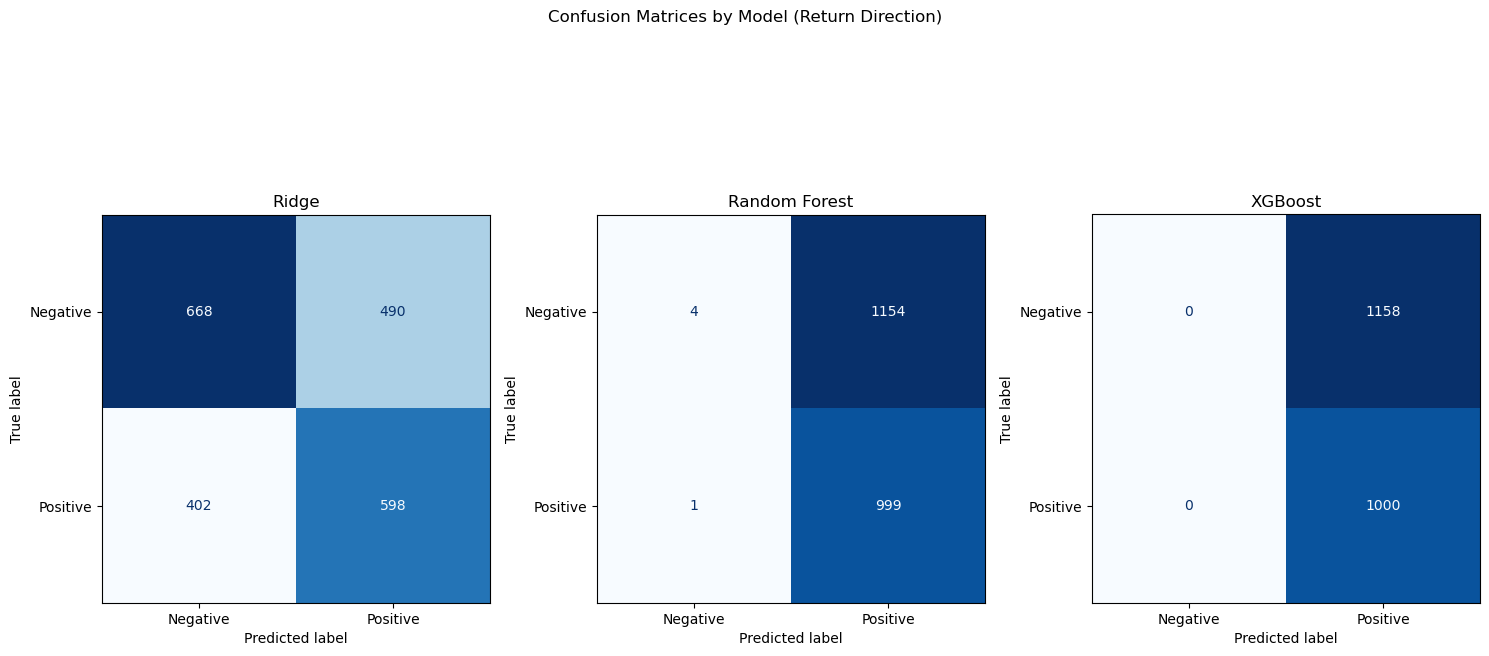

In [41]:
#Confusion matrices
ridge_bin=(np.sign(y_pred_ridge)>0).astype(int)
rf_bin=(np.sign(y_pred_rf)>0).astype(int)
xgb_bin=(np.sign(y_pred_xgb)>0).astype(int)

ridge_cm=confusion_matrix(y_true_bin,ridge_bin)
rf_cm=confusion_matrix(y_true_bin,rf_bin)
xgb_cm=confusion_matrix(y_true_bin,xgb_bin)

fig,axes=plt.subplots(1,3,figsize=(15,8))

for ax,cm,title in zip(axes,[ridge_cm, rf_cm, xgb_cm],["Ridge", "Random Forest", "XGBoost"]):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(ax=ax, colorbar=False, cmap="Blues")
    ax.set_title(title)

plt.suptitle("Confusion Matrices by Model (Return Direction)")
plt.tight_layout()
plt.show()

Clearly, our models perform terribly... Dissapointing, but this may be a result of the fact that we have made this a regression problem where the target is the raw return. The returns may be too close to random and are centered around 0 with most being tiny, especially since these are returns from the next trading day. Let's try again but with y = direction, such that this becomes a classification problem: 

In [44]:
#Separating features 
X=data.drop(columns=['return','direction'])
y=data['direction']

#Standardizing numeric features (all features should be numeric anyways)
numeric_cols=X.select_dtypes(include=['int64','float64']).columns
scaler=StandardScaler()
X_scaled=X.copy()
X_scaled[numeric_cols]=scaler.fit_transform(X[numeric_cols])

#Split into train and test sets 80/20
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=42)

In [47]:
ridge=RidgeClassifier()
ridge_params={'alpha':[0.01,0.1,1,10,50,100]}
grid_ridge=GridSearchCV(ridge,ridge_params,cv=5,scoring='accuracy')
grid_ridge.fit(X_train,y_train)
best_ridge=grid_ridge.best_estimator_
y_pred_ridge=best_ridge.predict(X_test)

ridge_acc=accuracy_score(y_test,y_pred_ridge) 
ridge_prec=precision_score(y_test,y_pred_ridge)
ridge_rec=recall_score(y_test,y_pred_ridge)
ridge_f1=f1_score(y_test,y_pred_ridge)

print("Ridge Regression:")
print("Best alpha: ",grid_ridge.best_params_)
print(f"Direction Accuracy: {ridge_acc:.4f}\n, Direction Precision: {ridge_prec:.4f}\n, Direction Recall: {ridge_rec:.4f}\n, Direction F1: {ridge_f1:.4f}\n")

Ridge Regression:
Best alpha:  {'alpha': 50}
Direction Accuracy: 0.6052
, Direction Precision: 0.5781
, Direction Recall: 0.5480
, Direction F1: 0.5626



In [49]:
rf=RandomForestClassifier(random_state=42)
rf_param_dist={
    'n_estimators':[100,200,500,1000],
    'max_depth':[5,10,20,None],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}
rf_random=RandomizedSearchCV(rf,param_distributions=rf_param_dist,n_iter=10,cv=3,scoring='accuracy',n_jobs=-1,random_state=42)
rf_random.fit(X_train,y_train)
best_rf=rf_random.best_estimator_
y_pred_rf=best_rf.predict(X_test)

rf_acc=accuracy_score(y_test,y_pred_rf)
rf_prec=precision_score(y_test,y_pred_rf)
rf_rec=recall_score(y_test,y_pred_rf)
rf_f1=f1_score(y_test,y_pred_rf)

print("Random Forest:")
print("Best params:",rf_random.best_params_)
print(f"Direction Accuracy: {rf_acc:.4f}\n, Direction Precision: {rf_prec:.4f}\n, Direction Recall: {rf_rec:.4f}\n, Direction F1: {rf_f1:.4f}\n")

/Users/enzo/opt/anaconda3/envs/PythonEnv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest:
Best params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}
Direction Accuracy: 0.5839
, Direction Precision: 0.5637
, Direction Recall: 0.4510
, Direction F1: 0.5011



In [51]:
xgb=XGBClassifier(random_state=42,use_label_encoder=False,eval_metric='logloss')
xgb_param_dist={
    'n_estimators':[100,200,500],
    'max_depth':[3,5,7],
    'learning_rate':[0.01,0.05,0.1],
    'subsample':[0.6,0.8,1]
}
xgb_random=RandomizedSearchCV(xgb,param_distributions=xgb_param_dist,n_iter=10,cv=3,scoring='accuracy',n_jobs=-1,random_state=42)
xgb_random.fit(X_train,y_train)
best_xgb=xgb_random.best_estimator_
y_pred_xgb=best_xgb.predict(X_test)

xgb_acc=accuracy_score(y_test,y_pred_xgb)
xgb_prec=precision_score(y_test,y_pred_xgb)
xgb_rec=recall_score(y_test,y_pred_xgb)
xgb_f1=f1_score(y_test,y_pred_xgb)


print("XGBoost:")
print("Best params:",xgb_random.best_params_)
print(f"Direction Accuracy: {xgb_acc:.4f}\n, Direction Precision: {xgb_prec:.4f}\n, Direction Recall: {xgb_rec:.4f}\n, Direction F1: {xgb_f1:.4f}\n")

/Users/enzo/opt/anaconda3/envs/PythonEnv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:03:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/enzo/opt/anaconda3/envs/PythonEnv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:03:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/enzo/opt/anaconda3/envs/PythonEnv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:03:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007592020/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/enzo/opt/anaconda3/envs/PythonEnv/lib/python3.12/site-pac

XGBoost:
Best params: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01}
Direction Accuracy: 0.5547
, Direction Precision: 0.5316
, Direction Recall: 0.3280
, Direction F1: 0.4057



In [52]:
#Feature importance 
ridge_importance=pd.Series(best_ridge.coef_[0],index=X_train.columns).sort_values(key=abs,ascending=False)
rf_importance=pd.Series(best_rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
xgb_importance=pd.Series(best_xgb.feature_importances_,index=X_train.columns).sort_values(ascending=False)

print("Top Ridge features:\n", ridge_importance.head(5))
print("\nTop RF features:\n", rf_importance.head(5))
print("\nTop XGB features:\n", xgb_importance.head(5))

Top Ridge features:
 headline_length   -0.054169
tick_ODFL         -0.054169
tick_OEC          -0.054169
tick_OFG          -0.054169
tick_OFIX         -0.054169
dtype: float64

Top RF features:
 finbert_pos        0.048311
finbert_neg        0.046192
finbert_neu        0.045444
headline_length    0.045335
word_count         0.026501
dtype: float64

Top XGB features:
 day_1       0.024065
results     0.019760
launches    0.018876
ffo         0.018817
day_2       0.017673
dtype: float32


In [54]:
results = {
    "Model": ["Ridge", "Random Forest", "XGBoost"],
    "Direction Accuracy": [ridge_acc, rf_acc, xgb_acc],
    "Direction Precision": [ridge_prec, rf_prec, xgb_prec],
    "Direction Recall": [ridge_rec, rf_rec, xgb_rec],
    "Direction F1": [ridge_f1, rf_f1, xgb_f1]
}

df = pd.DataFrame(results)
styled_table = (
    df.style
      .set_caption("Model Performance Comparison")
      .set_properties(**{
          "font-size": "12pt",
          "text-align": "center"
      })
      .hide(axis="index")
      .format({
          "Direction Acc.": "{:.4f}",
          "Precision": "{:.2f}",
          "Recall": "{:.2f}",
          "F1": "{:.2f}"
      })
)

styled_table

Model,Direction Accuracy,Direction Precision,Direction Recall,Direction F1
Ridge,0.605190,0.578059,0.548000,0.562628
Random Forest,0.583874,0.563750,0.451000,0.501111
XGBoost,0.554680,0.531605,0.328000,0.405690


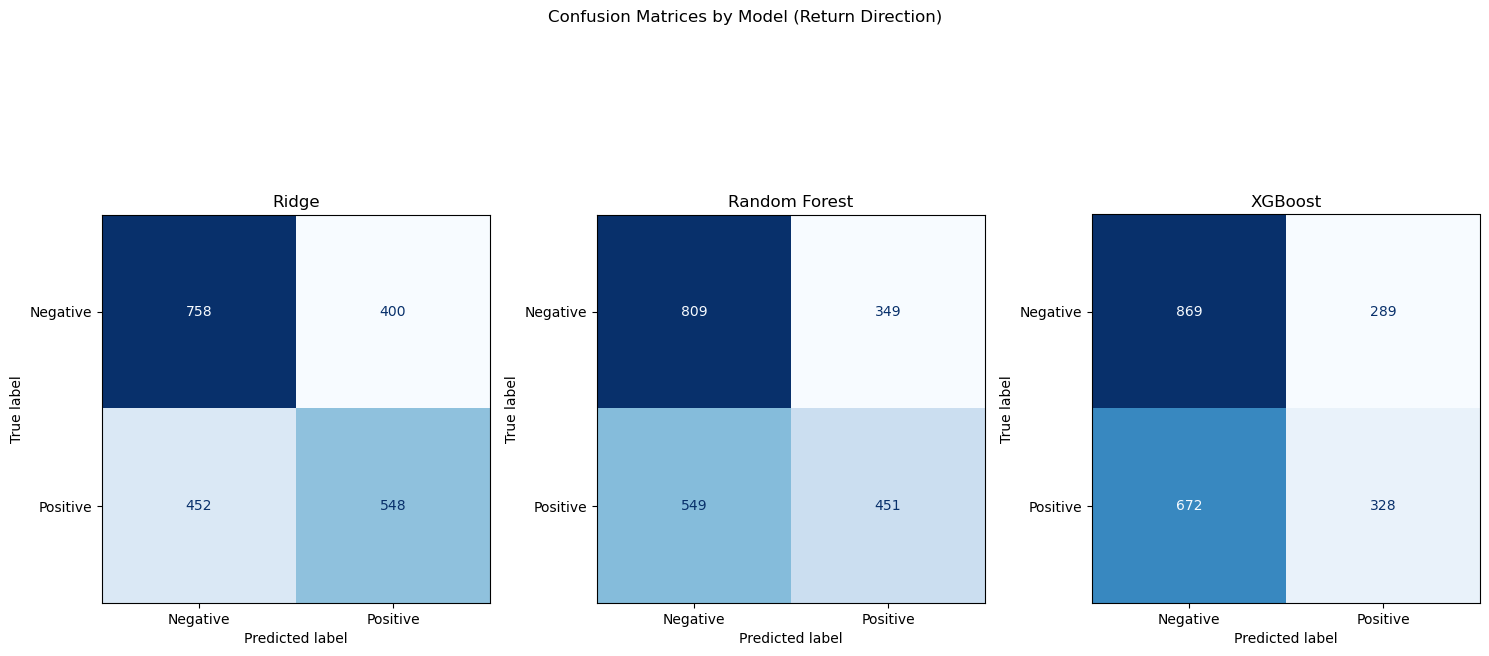

In [55]:
#Confusion matrices
ridge_cm=confusion_matrix(y_test,y_pred_ridge)
rf_cm=confusion_matrix(y_test,y_pred_rf)
xgb_cm=confusion_matrix(y_test,y_pred_xgb)

fig,axes=plt.subplots(1,3,figsize=(15,8))

for ax,cm,title in zip(axes,[ridge_cm, rf_cm, xgb_cm],["Ridge", "Random Forest", "XGBoost"]):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(ax=ax, colorbar=False, cmap="Blues")
    ax.set_title(title)

plt.suptitle("Confusion Matrices by Model (Return Direction)")
plt.tight_layout()
plt.show()